**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Autoencoder para colorear imagenes

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Referencias

1. Basadado en Rowel Atieza, [Advanced Deep Learning with TensorFlow 2 and Keras](https://www.amazon.com/-/es/Rowel-Atienza-ebook/dp/B0851D5YQQ), 2020.

## Contenido

* [Introducción](#Introducción)
* [Importa módulos](#Importa-módulos)
* [ Función para convertir una imagen a color en tonos de gris](#Función-para-convertir-una-imagen-a-color-en-tonos-de-gris)
* [Los datos](#Los-datos)
* [Configuración](#Configuración)
* [Encoder](#Encoder)
* [Decoder](#Decoder)
* [Autoencoder](#Autoencoder)
* [Callbacks](#Callbacks)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones y gráficas](#Predicciones-y-gráficas)

## Introducción

## Importa módulos

In [31]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np 
import matplotlib.pyplot as plt 
import os 
  
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape 
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.datasets import cifar100 
from tensorflow.keras.utils import plot_model



## Función para convertir una imagen a color en tonos de gris

In [17]:
def rgb_2_gray(image): 
    return np.dot(image[..., :3], [0.299, 0.587, 0.114]) 

## Los datos

Los datos son de la base [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html) creados en la Universidad de Toronto.

### Lee datos

In [13]:
(x_train, _), (x_test, _) = cifar100.load_data() 
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Crea imágenes en escala de grises

In [55]:
x_train_gray = x_train[..., :3]@[0.299, 0.587, 0.114]
x_test_gray  = x_test[..., :3]@[0.299, 0.587, 0.114]

# Reshape to the model
x_train_gray = np.expand_dims(x_train_gray , axis=3)
x_test_gray = np.expand_dims(x_test_gray, axis=3)

print(x_train_gray.shape)
print(x_test_gray.shape)


(50000, 32, 32, 1)
(10000, 32, 32, 1)


### Normaliza datos

In [28]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
  
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

## Configuración

In [57]:
rows = 32
cols = 32
channels = 3

input_shape = (rows, cols, 1) 
batch_size = 256
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256] 

## Encoder

In [36]:
inputs = Input(shape = input_shape) 
x = inputs 
for filters in layer_filters: 
  x = Conv2D(filters = filters, 
           kernel_size = kernel_size, 
           strides = 2, 
           activation ='relu', 
           padding ='same')(x) 

# Save the shape to the decoder
shape = x.shape.as_list()
# shape = shape[1:]

x = Flatten()(x) 
latent = Dense(latent_dim, name ='latent_vector')(x) 
encoder_colorizing = Model(inputs, latent, name ='encoder_colorizing') 

### Summary

Model: "encoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
______________________________________

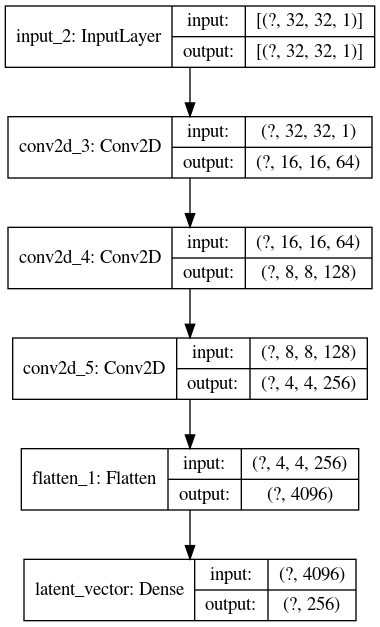

In [34]:
encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='../Imagenes/encoder_colorizing.png',show_shapes=True)

## Decoder

In [42]:
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input') 
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) 
x = Reshape((shape[1], shape[2], shape[3]))(x) 
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)- 
# Conv2DTranspose(64) 
for filters in layer_filters[::-1]: 
  x = Conv2DTranspose(filters = filters, 
                      kernel_size = kernel_size, 
                      strides = 2, 
                      activation ='relu', 
                      padding ='same')(x) 

outputs = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(x) 
decoder_colorizing = Model(latent_inputs, outputs, name ='decoder_colorizing') 

In [ ]:
for filters in layer_filters: 
  x = Conv2D(filters = filters, 
           kernel_size = kernel_size, 
           strides = 2, 
           activation ='relu', 
           padding ='same')(x) 

### Summary

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)  

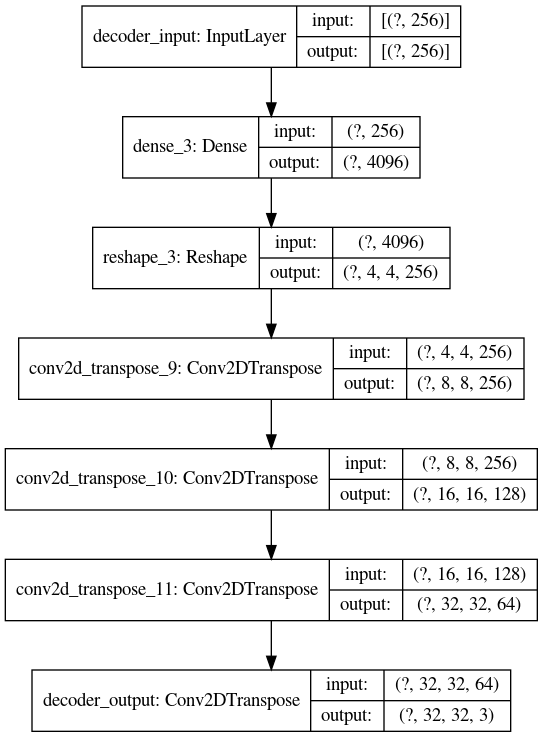

In [43]:
decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='../Imagenes/decoder_colorizing.png',show_shapes=True)

## Autoencoder

In [45]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing') 

### Summary

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder_colorizing (Model)   (None, 256)               1418496   
_________________________________________________________________
decoder_colorizing (Model)   (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


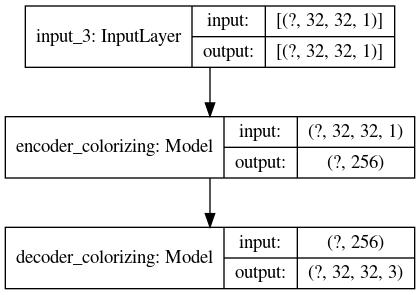

In [47]:
autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='../Imagenes/autoencoder_colorizing.png',show_shapes=True)

## Callbacks

In [69]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

## Compila

In [51]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

## Entrena


autoencoder_colorizing.fit(x_train_gray, 
                x_train, 
                validation_data =(x_test_gray, x_test), 
                epochs = epochs, 
                batch_size = batch_size) 


In [70]:
epochs = 10

autoencoder_colorizing.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
49920/50000 [============================>.] - ETA: 0s - loss: 0.0115 - mae: 0.0753
Epoch 00001: val_loss improved from inf to 0.01195, saving model to /home/alvaro/Diplomado_AI/AutoEncoders/Cuadernos/saved_models/colorized_ae_model.001.h5
50000/50000 [==============================] - 670s 13ms/sample - loss: 0.0115 - mae: 0.0753 - val_loss: 0.0120 - val_mae: 0.0767
Epoch 2/10
49920/50000 [============================>.] - ETA: 1s - loss: 0.0112 - mae: 0.0743
Epoch 00002: val_loss improved from 0.01195 to 0.01194, saving model to /home/alvaro/Diplomado_AI/AutoEncoders/Cuadernos/saved_models/colorized_ae_model.002.h5
50000/50000 [==============================] - 698s 14ms/sample - loss: 0.0112 - mae: 0.0743 - val_loss: 0.0119 - val_mae: 0.0763
Epoch 3/10
49920/50000 [============================>.] - ETA: 1s - loss: 0.0109 - mae: 0.0733
Epoch 00003: val_loss improved from 0.01194 to 0.01168, saving model to /home/alvaro/Dipl

## Predicciones y gráficas

In [75]:
x_decoded = autoencoder_colorizing.predict(x_test_gray)

### Imágenes originales

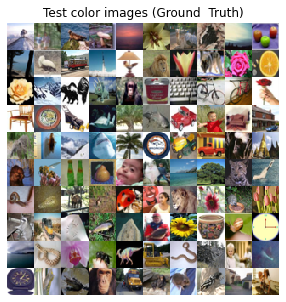

In [89]:
# display the 1st 100 input images (color and gray)

img_rows = rows
img_cols = cols

imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % '../Imagenes/')
plt.show()

### Imágenes en escala de grises

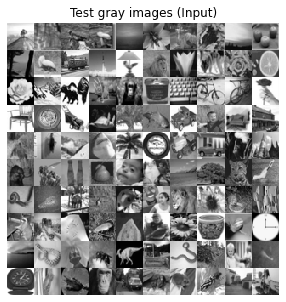

In [87]:
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % '../Imagenes/')
plt.show()

### Primeras 100 imágenes coloreadas

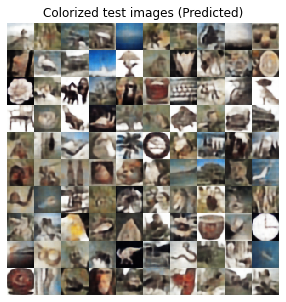

In [88]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % '../Imagenes/')
plt.show()